<a href="https://colab.research.google.com/github/alirezaghl/Alzheimer-s-stages-classification/blob/main/AlzheimerR18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader


import os

In [ ]:
!pip install unrar
!unrar x '/content/Alzheimer kaggle.rar'

In [3]:
train_dir = '/content/Alzheimer_s Dataset/train'
test_dir = '/content/Alzheimer_s Dataset/test'

In [4]:
train_trans = tt.Compose([
    tt.Resize(255),
    tt.CenterCrop(224),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(10),
    tt.RandomGrayscale(),
    tt.RandomAffine(translate=(0.05,0.05), degrees=0),
    tt.ToTensor(),
    tt.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [5]:
test_trans = tt.Compose([
             tt.Resize(255),
             tt.CenterCrop(224), 
             tt.ToTensor(),
             tt.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])        
])

In [6]:
testset = ImageFolder(test_dir, transform = test_trans)

In [7]:
trainset = ImageFolder(train_dir, transform = train_trans)

In [105]:
class_names = trainset.classes

In [106]:
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [10]:
y_train=[y for _,y in trainset]        # As you can see data is imbalanced
counter_train=Counter(y_train)
counter_train

Counter({0: 717, 1: 52, 2: 2560, 3: 1792})

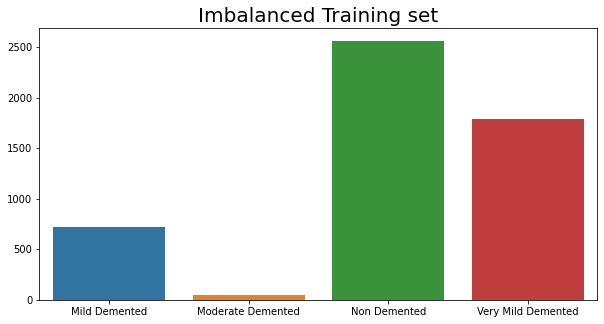

In [23]:
train_samplesize = pd.DataFrame.from_dict(
    {'Mild Demented': [len([os.path.join('/content/Alzheimer_s Dataset/train/MildDemented', filename) 
                     for filename in os.listdir('/content/Alzheimer_s Dataset/train/MildDemented')])], 
     'Moderate Demented': [len([os.path.join('/content/Alzheimer_s Dataset/train/ModerateDemented', filename) 
                        for filename in os.listdir('/content/Alzheimer_s Dataset/train/ModerateDemented')])],
     'Non Demented': [len([os.path.join('/content/Alzheimer_s Dataset/train/NonDemented', filename) 
                        for filename in os.listdir('/content/Alzheimer_s Dataset/train/NonDemented')])],
                     
     'Very Mild Demented': [len([os.path.join('/content/Alzheimer_s Dataset/train/VeryMildDemented', filename) 
                        for filename in os.listdir('/content/Alzheimer_s Dataset/train/VeryMildDemented')])]})

sns.barplot(data=train_samplesize).set_title('Imbalanced Training set', fontsize=20)
plt.show()

In [28]:
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Mild Demented", fontsize=20)
        elif 5<=i<10:
            ax[i//5][i%5].set_title("Moderate Demented", fontsize=20)
        elif 10<=i<15:
          ax[i//5][i%5].set_title("Non Demented", fontsize=20)
        elif 15<=i<20:
          ax[i//5][i%5].set_title("Very Mild Demented", fontsize=20)
        ax[i//5][i%5].axis('off')

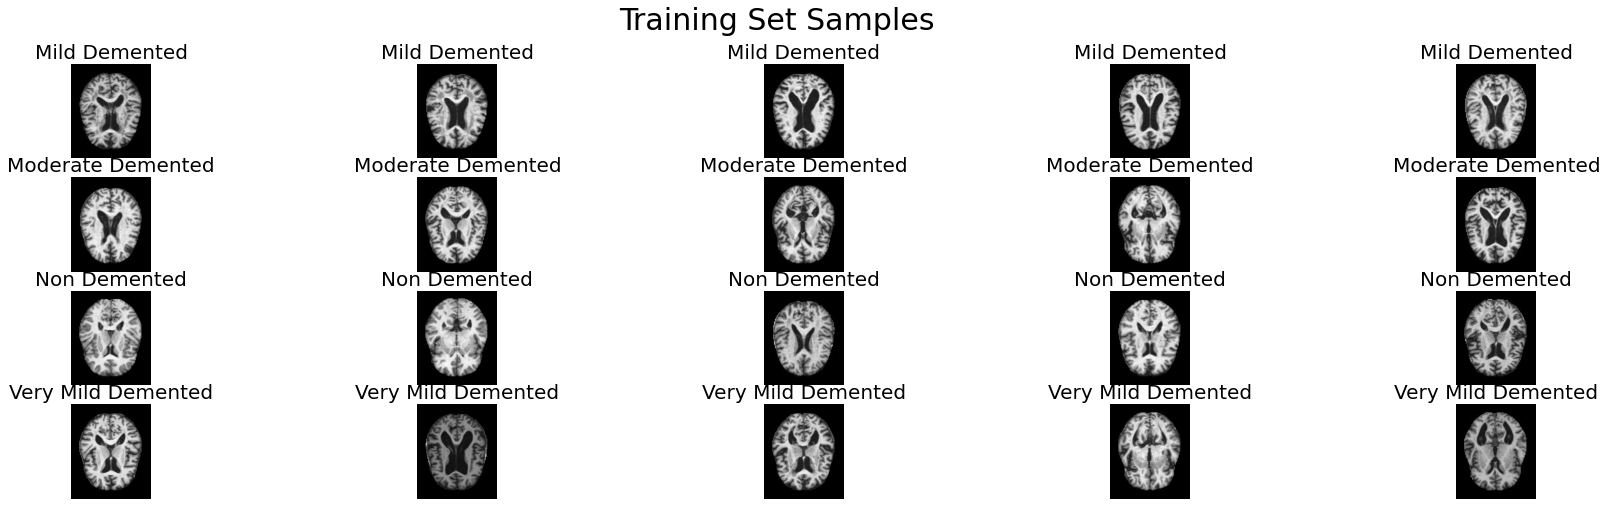

In [29]:
rand_samples = rand_samples = random.sample([os.path.join('/content/Alzheimer_s Dataset/train/MildDemented', filename) 
                              for filename in os.listdir('/content/Alzheimer_s Dataset/train/MildDemented')], 5) + \
    random.sample([os.path.join('/content/Alzheimer_s Dataset/train/ModerateDemented', filename) 
                   for filename in os.listdir('/content/Alzheimer_s Dataset/train/ModerateDemented')], 5) + \
              random.sample([os.path.join('/content/Alzheimer_s Dataset/train/NonDemented', filename) 
                   for filename in os.listdir('/content/Alzheimer_s Dataset/train/NonDemented')], 5) + \
              random.sample([os.path.join('/content/Alzheimer_s Dataset/train/VeryMildDemented', filename) 
                   for filename in os.listdir('/content/Alzheimer_s Dataset/train/VeryMildDemented')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

In [11]:
total_c = 717 + 52 + 2560 + 1792       # calcultaing the total number of classes

In [8]:
train_size = round(len(trainset)*0.7) 
val_size = len(trainset) - train_size 

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)

(3585, 1536)

visualization of training dataset and validation dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [1044  828  631   51]
torch.Size([3, 228, 906])


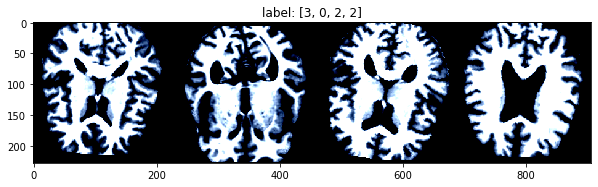

In [15]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(66)


def show(img,y,color=True):
    # convert tensor to numpy array
    npimg = img.numpy()
   
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1,2,0))
    
    if color==False:
        npimg_tr=npimg_tr[:,:,0]
        plt.imshow(npimg_tr,interpolation='nearest')
    else:
        # display images
        plt.imshow(npimg_tr,interpolation='nearest')
    plt.title("label: "+str(y))

grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ds[i][0] for i in rnd_inds]
y_grid_train=[train_ds[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train,y_grid_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [1146 1103  661  307]
torch.Size([3, 228, 906])


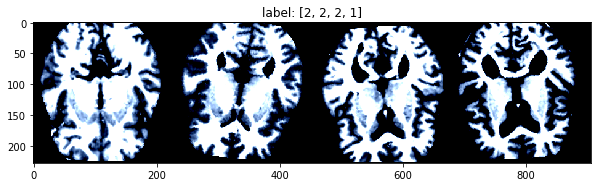

In [16]:
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ds[i][0] for i in range(grid_size)]
y_grid_val=[val_ds[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)

show(x_grid_val,y_grid_val)

Data loaders!\
I use this batch size because I didn't have enough computational power,
this is the highest one that I was able to work with.

In [30]:
batch_size=32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=0)

In [31]:
test_dl = DataLoader(testset, batch_size = 128, shuffle = True) 

Creating helper functions for transfering data to GPU

In [32]:
def get_default_device():
   
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [33]:
def to_device(data, device):
  
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [34]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device) 

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Helper functions for training the model

In [35]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [121]:
class AlzheimerModelBase(nn.Module):
    
   
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      
        loss = F.cross_entropy(out, labels, weight=weight)      
        acc,preds = accuracy(out, labels)                       
        
        return {'train_loss': loss, 'train_acc':acc}
       
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['train_acc'] for x in outputs]          
        epoch_acc = torch.stack(batch_accs).mean()              
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      
        loss = F.cross_entropy(out, labels)                     
        acc,preds = accuracy(out, labels)                       
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]           
        epoch_acc = torch.stack(batch_accs).mean()              
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
    
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}  

In [122]:
residual = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [123]:
class Alzheimeresnet(AlzheimerModelBase):
    def __init__(self):
        super().__init__()
        self.network = torchvision.models.resnet18(pretrained=True)
        num_features = self.network.fc.in_features 
        self.network.fc = nn.Linear(num_features, 4) 
    
    def forward(self, xb):
        return self.network(xb)

residual = Alzheimeresnet().to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [94]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader, weight, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache() 
    history = {}
    
    
    optimizer = opt_func(model.parameters(), lr)

    best_loss = 1 
    for epoch in range(epochs):
        
         
        model.train() 
        train_outputs = []      
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']    
            train_outputs.append(outputs)
            train_results = model.train_epoch_end(train_outputs)                        
            loss.backward()                                       
            optimizer.step()                                 
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))                               
            

          
        
        val_results = evaluate(model, val_loader)
        
        
        if val_results['val_loss'] < best_loss and epoch + 1 > 15:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
        
        model.epoch_end(epoch, train_results, val_results)
        
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
    
    model.load_state_dict(best_model_wts)                         
    
    return history, optimizer, best_loss


Because we are working on an imbalanced data,\
I`ve applied class weighting and add it to the loss function.

In [125]:
n_epochs = 30
lr = 0.001
opt_func = torch.optim.Adam
weight = torch.FloatTensor([717/(total_c), 52/(total_c), 2560/(total_c), 1792/(total_c)]).to(device)

In [126]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [103]:
history, optimizer, best_loss = fit(n_epochs, lr, residual, train_dl, val_dl, weight, opt_func=opt_func)

Epoch [1], train_loss: 0.7349, train_acc: 0.5689, val_loss: 6.9304, val_acc: 0.4902
Epoch [2], train_loss: 0.6557, train_acc: 0.6056, val_loss: 0.8902, val_acc: 0.5866
Epoch [3], train_loss: 0.6176, train_acc: 0.6294, val_loss: 2.0946, val_acc: 0.4993
Epoch [4], train_loss: 0.5923, train_acc: 0.6466, val_loss: 0.8786, val_acc: 0.6048
Epoch [5], train_loss: 0.5651, train_acc: 0.6662, val_loss: 0.9130, val_acc: 0.6523
Epoch [6], train_loss: 0.5347, train_acc: 0.6941, val_loss: 1.1006, val_acc: 0.5788
Epoch [7], train_loss: 0.5008, train_acc: 0.7270, val_loss: 1.2622, val_acc: 0.5729
Epoch [8], train_loss: 0.4640, train_acc: 0.7409, val_loss: 0.8502, val_acc: 0.6953
Epoch [9], train_loss: 0.4236, train_acc: 0.7553, val_loss: 1.5755, val_acc: 0.6139
Epoch [10], train_loss: 0.4233, train_acc: 0.7685, val_loss: 1.5143, val_acc: 0.6465
Epoch [11], train_loss: 0.3680, train_acc: 0.7904, val_loss: 0.8407, val_acc: 0.7507
Epoch [12], train_loss: 0.3371, train_acc: 0.8081, val_loss: 0.9432, val_a

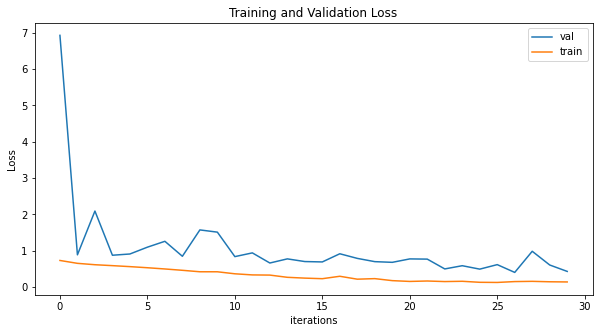

In [113]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(history['val_loss'], label="val")
plt.plot(history['train_loss'], label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

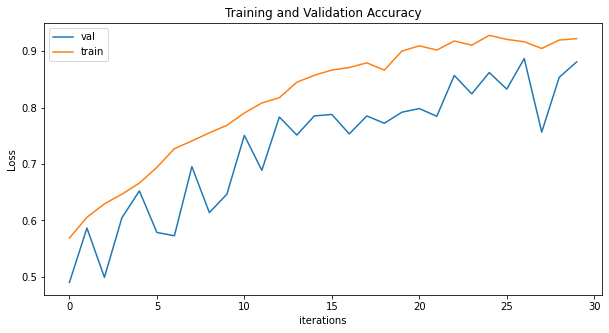

In [114]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(history['val_acc'], label="val")
plt.plot(history['train_acc'], label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [104]:
correct_count, all_count = 0, 0
for images,labels in test_dl:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 3, 224, 224)
    with torch.no_grad():
        logps = residual(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 1279

Model Accuracy = 0.7036747458952306


Hmm, overfitting! Considering the imbalanced nature of the data, actually this is not a bad accuracy. We can improve accuracy and overfitting problem in several ways, for example by setting up a learning scheduler or add regularization.\
It is also important to keep in mind that accuracy is not a good evaluation of an imbalanced data and it was better to use f1 score as a evaluation method for this datasets. 

In [116]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [124]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader, weight, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache() 
    history = {}
    
    
    optimizer = opt_func(model.parameters(), lr, weight_decay=1e-5) # weight decay
    lr_scheduler = CosineAnnealingLR(optimizer,T_max=5,eta_min=1e-6) # learning scheduler

    best_loss = 1 
    for epoch in range(epochs):
        
         
        model.train() 
        train_outputs = []      
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']    
            train_outputs.append(outputs)
            train_results = model.train_epoch_end(train_outputs)                        
            loss.backward()                                       
            optimizer.step()                                 
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))                               
            

          
        
        val_results = evaluate(model, val_loader)
        lr_scheduler.step()
        
        
        if val_results['val_loss'] < best_loss and epoch + 1 > 15:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
        
        model.epoch_end(epoch, train_results, val_results)
        
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
    
    model.load_state_dict(best_model_wts)                         
    
    return history, optimizer, best_loss


In [127]:
history, optimizer, best_loss = fit(n_epochs, lr, residual, train_dl, val_dl, weight, opt_func=opt_func)

Epoch [1], train_loss: 0.7407, train_acc: 0.5539, val_loss: 1.0516, val_acc: 0.5632
Epoch [2], train_loss: 0.6558, train_acc: 0.5990, val_loss: 0.9700, val_acc: 0.5345
Epoch [3], train_loss: 0.5983, train_acc: 0.6493, val_loss: 0.9302, val_acc: 0.6504
Epoch [4], train_loss: 0.4834, train_acc: 0.7193, val_loss: 0.7820, val_acc: 0.6855
Epoch [5], train_loss: 0.3473, train_acc: 0.7981, val_loss: 0.5837, val_acc: 0.7858
Epoch [6], train_loss: 0.3128, train_acc: 0.8296, val_loss: 0.5830, val_acc: 0.8021
Epoch [7], train_loss: 0.2658, train_acc: 0.8487, val_loss: 0.5494, val_acc: 0.8158
Epoch [8], train_loss: 0.3571, train_acc: 0.7954, val_loss: 1.2588, val_acc: 0.5983
Epoch [9], train_loss: 0.4688, train_acc: 0.7483, val_loss: 1.1910, val_acc: 0.6348
Epoch [10], train_loss: 0.4824, train_acc: 0.7259, val_loss: 1.2379, val_acc: 0.6322
Epoch [11], train_loss: 0.4244, train_acc: 0.7558, val_loss: 0.7782, val_acc: 0.7383
Epoch [12], train_loss: 0.3551, train_acc: 0.8158, val_loss: 0.9294, val_a

In [128]:
correct_count, all_count = 0, 0
for images,labels in test_dl:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 3, 224, 224)
    with torch.no_grad():
        logps = residual(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 1279

Model Accuracy = 0.7584050039093041


Yes! with adding regularization and Cosine Annealing  learning scheduler we improve our model accuracy about five percent!